# Train a model to learn the shape in an image

Shape categories are: Ellipse, Rectangle, Triangle and Other  
Using Supervised Learning with Tensorflow

Data is received in 3 pickles that contain:
1. Train images and labels
2. Validation images and labels
3. Test images and labels

---
Francois Robert

In [1]:
# Load packages

from IPython.display import display, Image
import imageio
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg
%matplotlib inline

import os
import sys
from six.moves import cPickle as pickle

In [2]:
import numpy as np

from pathlib import Path
from sklearn.metrics import confusion_matrix
import itertools

In [3]:
import tensorflow as tf

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, load_model   
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Input, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing import image

import datetime
datetime.datetime.now()

datetime.datetime(2022, 10, 1, 13, 57, 43, 663968)

In [4]:
from platform import python_version
print(python_version())

3.9.13


In [5]:
import tensorflow as tf
print(tf.__version__)

2.10.0


In [6]:
seed1 = 129
np.random.seed(seed1)

In [7]:
# GPU Setting
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

Metal device set to: Apple M1 Max


2022-10-01 13:57:43.677820: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-10-01 13:57:43.677963: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Define environment variables

In [8]:
BASEDIR = ".."

PICKLE_DIR     = os.path.join(BASEDIR, 'pickles')
TRAIN_DATAFILE = os.path.join(PICKLE_DIR, 'train.pickle')
VAL_DATAFILE   = os.path.join(PICKLE_DIR, 'val.pickle')
TEST_DATAFILE  = os.path.join(PICKLE_DIR, 'test.pickle')

MODEL_DIR      = os.path.join(BASEDIR, "saved_models")
model_name     = os.path.join(MODEL_DIR, "shapes.model.01") 

image_size     = 70 # Pixel width and height
pixel_depth    = 255.0  # Number of levels per pixel

In [9]:
# Create Model directory
Path(MODEL_DIR).mkdir(parents=True, exist_ok=True)

## Load train, validation and test datasets from Pickles

In [10]:
with open(TRAIN_DATAFILE, 'rb') as file:
    train_dict = pickle.load(file)
with open(VAL_DATAFILE, 'rb') as file:
    val_dict = pickle.load(file)
with open(TEST_DATAFILE, 'rb') as file:
    test_dict = pickle.load(file)

In [11]:
output_labels = [
  'other',     #    0
  'ellipse',   #    1
  'rectangle', #    2
  'triangle']  #    3

num_classes = len(output_labels)

In [12]:
## Construct train set
train_X = train_dict['train_data']
train_y = train_dict['train_labels']

In [13]:
## Construct validation set
val_X = val_dict['val_data']
val_y = val_dict['val_labels']

In [14]:
print("train_X shape: ", train_X.shape)
print("train_y shape: ", train_y.shape)

train_X shape:  (21386, 70, 70)
train_y shape:  (21386,)


In [15]:
print("val_X shape: ", val_X.shape)
print("val_y shape: ", val_y.shape)

val_X shape:  (3983, 70, 70)
val_y shape:  (3983,)


In [16]:
# Reshape images to add the channel (height = 70px, width = 70px , channel = 1)
X_train = train_X.reshape(-1,image_size,image_size,1)
X_val   = val_X.reshape(-1,image_size,image_size,1)

In [17]:
# Encode labels to one hot vectors (ex : C -> [0,0,1,0]) using Keras one Hot encoding
Y_train = to_categorical(train_y, num_classes = num_classes)
Y_val   = to_categorical(val_y, num_classes = num_classes)

In [18]:
print("X_train shape: ", X_train.shape)
print("X_val shape: ", X_val.shape)
print("Y_train shape: ", Y_train.shape)
print("Y_val shape: ", Y_val.shape)

X_train shape:  (21386, 70, 70, 1)
X_val shape:  (3983, 70, 70, 1)
Y_train shape:  (21386, 4)
Y_val shape:  (3983, 4)


In [19]:
def plot_sample(image, axs):
    axs.imshow(image.reshape(image_size, image_size), cmap="gray")

In [20]:
def display_images(X, Y):
    """ 
    This function shows images with their real labels
    Presentation is rows of 10 images
    """

    fig = plt.figure(figsize=(13, 10))
    fig.subplots_adjust(hspace=0.2,wspace=0.2,
                        left=0, right=1, bottom=0, top=1.7)
    nb_pictures = len(X)
    nb_per_row = 10
    nb_of_row  = (nb_pictures - 1) // nb_per_row + 1

    for i in range(nb_pictures):
        ax = fig.add_subplot(nb_of_row, nb_per_row, i+1, xticks=[], yticks=[]) 
        plot_sample(X[i].reshape((image_size, image_size)), ax)
        ax.set_title("{}".format(output_labels[Y[i]]))
    plt.show()

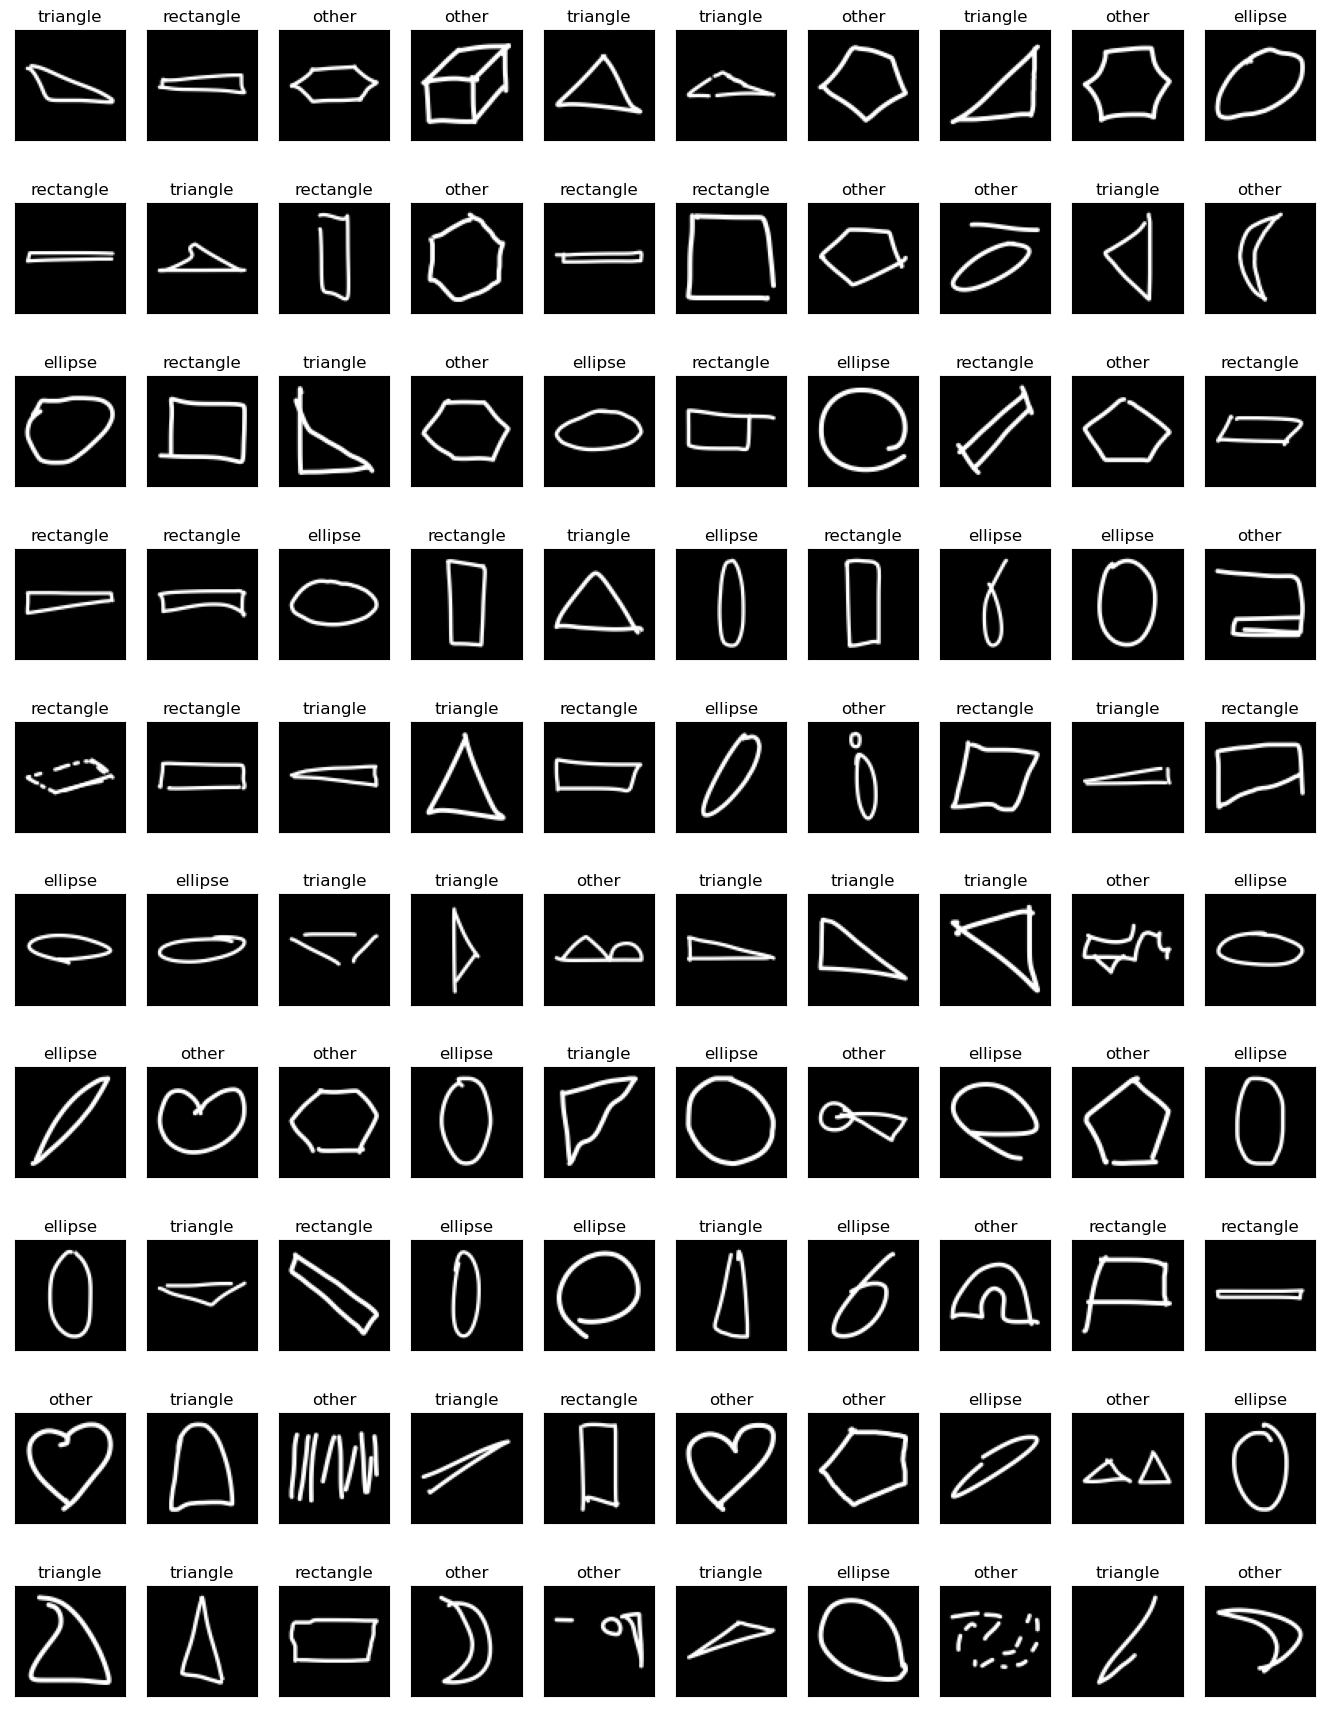

In [21]:
# Show random images from the Train Set
indexes = np.arange(len(train_y))
np.random.shuffle(indexes)
first_random_indexes_tr = indexes[:100]

display_images(X_train[first_random_indexes_tr], train_y[first_random_indexes_tr])

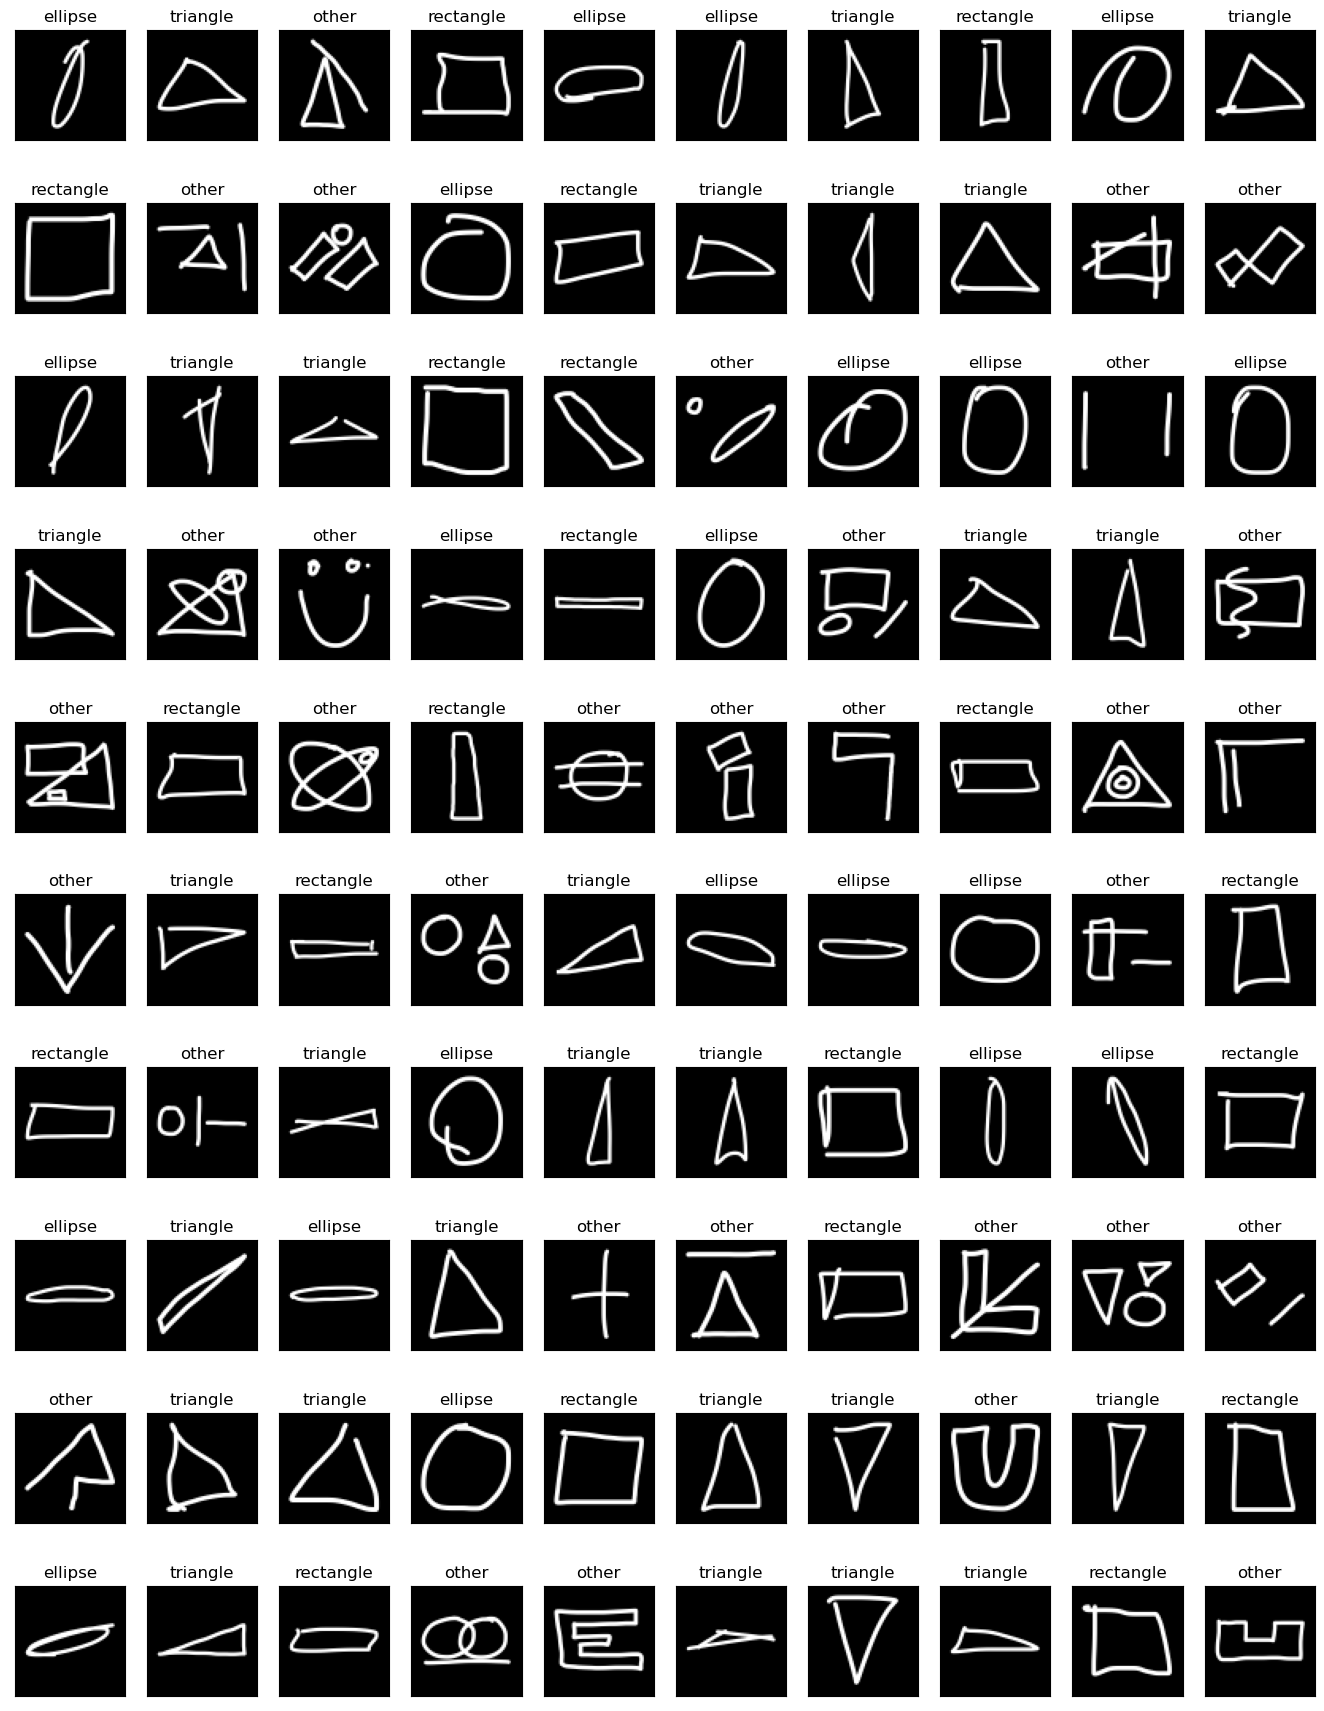

In [22]:
# Show random images from the Validation Set
indexes = np.arange(len(val_y))
np.random.shuffle(indexes)
first_random_indexes_va = indexes[:100]

display_images(X_val[first_random_indexes_va], val_y[first_random_indexes_va])

In [23]:
tf.keras.backend.clear_session()

## Define Deep Learning Model

In [24]:
def get_model_cnn():
    # Set the CNN model using Keras functional API
    input_img = Input(shape=(image_size, image_size, 1))

    x = Conv2D(32, (5, 5), padding='same')(input_img)  # Conv2D 1
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(32, (5, 5), padding='same')(x)          # Conv2D 2
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3))(x)                          # Conv2D 3
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = Conv2D(64, (3, 3))(x)                          # Conv2D 4
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(128, (3, 3))(x)                         # Conv2D 5
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(128, (3, 3))(x)                         # Conv2D 6
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.3)(x) 

    x = Flatten()(x)
    x = Dense(200)(x) 
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=input_img, outputs=output)
    
    return model

In [25]:
# select a model
model = get_model_cnn()

model.summary()

2022-10-01 13:57:46.643359: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-10-01 13:57:46.643377: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 70, 70, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 70, 70, 32)        832       
                                                                 
 batch_normalization (BatchN  (None, 70, 70, 32)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 70, 70, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 35, 35, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 35, 35, 32)        25632 

## Data augmentation: Full rotation, Flip vert. and Horiz.

### Augmentation helps overfit a lot
A rotation of +/-180 degrees is 360 degrees. With the addition of both flips, this means that even for
something like 300 epochs, the same exact image **will almost never be seen twice**. This **helps a lot** for the overfit. It allows the model to focus on the essence of each specific shape... as long as hyper-parameters such as learning rate are set correctly.

### Data generation 
Note that all the data was created from within tooling in [Mix on Pix](https://apps.apple.com/us/app/mix-on-pix-text-on-photos/id633281586). So some characteristics are pretty constant like:  
- Stroke width
- Margins
- Color

In [26]:
datagen = ImageDataGenerator(
        rotation_range=180,                  # Randomly rotate images in the range (degrees, 0 to +/-180)
#         zoom_range = [0.98, 1.02],         # Randomly zoom image a bit. Not required
        horizontal_flip=True,                # Randomly horizontal flip 
        vertical_flip=True)                  # Randomly vertical flip

# datagen.fit(X_train)

## Define the optimizer

In [27]:
# Adam is generally my best bet for such classifications
optimizer = Adam(lr=2e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0, amsgrad=False)

/Users/frobert/miniforge-envs/tensorflow-test/env/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


## Compile the model

In [28]:
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [29]:
# Keras callback to show the result of the best epoch in the model
# Intended to work with ModelCheckpoint callback.
class ShowBestEpochResult(tf.keras.callbacks.Callback):
    def __init__(self, on_param='val_loss', show_params=['val_loss', 'loss'], mode='min'):
        self.on_param    = on_param
        self.show_params = show_params
        self.mode        = mode

    def on_train_begin(self, logs=None):
        # The number of epoch at which the best value is found.
        self.best_epoch = 0

        # The best value found for the on_param.
        self.best = np.Inf
        if self.mode == 'max':
            self.best = np.NINF
            
        # The values on best epoch for each param in show_param.
        self.best_values = {}

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get(self.on_param)
        save_as_best = (self.mode=='min' and current < self.best) or \
                       (self.mode=='max' and current > self.best)

        if save_as_best: 
            self.best = current
            for param in self.show_params:
                self.best_values[param] = logs.get(param)
            self.best_epoch = epoch

    def on_train_end(self, logs=None):
        print(f"BestEpochResult. Epoch: {self.best_epoch+1},", end=" ")

        for param in self.best_values:
            print(f"{param}: {self.best_values[param]:.5f},", end=" ")
        print(" ")

In [30]:
# Lower the learning rate if accuracy stops improving.
#
# Since the 360 rotation and the flips in Data Augmentation put a lot of variability in the Traning data,
# I typically run 200 to 300 epochs and only lower the learning rate very slowly.
# So, the correct setting for patience and factor will be important to reach the best accuracy.
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=15,
                                            verbose=1,
                                            factor=0.9,
                                            min_lr=0.000000001)

## Fit the model with data Augmentation

In [31]:
# I like to start a few epoch with a small batch size because:
# - This basically makes the learning rate larger. https://openreview.net/pdf?id=B1Yy1BxCZ#:~:text=Increasing%20the%20batch%20size%20during%20training%20achieves%20similar%20results%20to,twice%20to%20illustrate%20the%20variance.
# - This covers to 0 to 80% of the accuracy curve, cleaning the graphs
epochs = 2 
batch_size = 32
history = model.fit(datagen.flow(X_train,Y_train, batch_size=batch_size, seed=seed1),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 1, steps_per_epoch=X_train.shape[0] // batch_size)

Epoch 1/2


2022-10-01 13:57:47.005537: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-10-01 13:57:47.371364: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


666/668 [============================>.] - ETA: 0s - loss: 0.7577 - accuracy: 0.6949

2022-10-01 13:58:08.002943: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


668/668 [==============================] - 22s 27ms/step - loss: 0.7567 - accuracy: 0.6954 - val_loss: 0.4151 - val_accuracy: 0.8511
Epoch 2/2
668/668 [==============================] - 15s 22ms/step - loss: 0.3713 - accuracy: 0.8634 - val_loss: 0.1638 - val_accuracy: 0.9430


In [32]:
# Save the Best model
h5_path    = model_name + ".h5"
checkpoint = ModelCheckpoint(h5_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

best_epoch_results = ShowBestEpochResult(on_param='val_accuracy', show_params=['val_accuracy', 'accuracy', 'val_loss', 'loss'], mode='max')

callbacks_list = [learning_rate_reduction, checkpoint, best_epoch_results]

epochs = 300 # Training per epoch: CPU (~150s) vs GPU (~6s) per epoch, so 25 times faster!
batch_size = 128
history = model.fit(datagen.flow(X_train,Y_train, batch_size=batch_size, seed=seed1),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 1, steps_per_epoch=X_train.shape[0] // batch_size,
                              callbacks=callbacks_list)

Epoch 1/300
167/167 [==============================] - ETA: 0s - loss: 0.2086 - accuracy: 0.9260
Epoch 1: val_accuracy improved from -inf to 0.95682, saving model to ../saved_models/shapes.model.01.h5
167/167 [==============================] - 9s 42ms/step - loss: 0.2086 - accuracy: 0.9260 - val_loss: 0.1322 - val_accuracy: 0.9568 - lr: 0.0020
Epoch 2/300
167/167 [==============================] - ETA: 0s - loss: 0.1773 - accuracy: 0.9373
Epoch 2: val_accuracy improved from 0.95682 to 0.96033, saving model to ../saved_models/shapes.model.01.h5
167/167 [==============================] - 7s 41ms/step - loss: 0.1773 - accuracy: 0.9373 - val_loss: 0.1154 - val_accuracy: 0.9603 - lr: 0.0020
Epoch 3/300
167/167 [==============================] - ETA: 0s - loss: 0.1612 - accuracy: 0.9426
Epoch 3: val_accuracy improved from 0.96033 to 0.96585, saving model to ../saved_models/shapes.model.01.h5
167/167 [==============================] - 7s 42ms/step - loss: 0.1612 - accuracy: 0.9426 - val_loss:

166/167 [============================>.] - ETA: 0s - loss: 0.0836 - accuracy: 0.9721
Epoch 27: val_accuracy did not improve from 0.98343
167/167 [==============================] - 7s 41ms/step - loss: 0.0836 - accuracy: 0.9722 - val_loss: 0.1683 - val_accuracy: 0.9480 - lr: 0.0020
Epoch 28/300
166/167 [============================>.] - ETA: 0s - loss: 0.0837 - accuracy: 0.9714
Epoch 28: val_accuracy did not improve from 0.98343
167/167 [==============================] - 7s 41ms/step - loss: 0.0836 - accuracy: 0.9714 - val_loss: 0.0488 - val_accuracy: 0.9814 - lr: 0.0020
Epoch 29/300
166/167 [============================>.] - ETA: 0s - loss: 0.0748 - accuracy: 0.9735
Epoch 29: val_accuracy improved from 0.98343 to 0.98418, saving model to ../saved_models/shapes.model.01.h5
167/167 [==============================] - 7s 41ms/step - loss: 0.0747 - accuracy: 0.9736 - val_loss: 0.0477 - val_accuracy: 0.9842 - lr: 0.0020
Epoch 30/300
166/167 [============================>.] - ETA: 0s - loss: 

167/167 [==============================] - ETA: 0s - loss: 0.0582 - accuracy: 0.9791
Epoch 54: val_accuracy did not improve from 0.98694
167/167 [==============================] - 7s 41ms/step - loss: 0.0582 - accuracy: 0.9791 - val_loss: 0.0686 - val_accuracy: 0.9804 - lr: 0.0020
Epoch 55/300
166/167 [============================>.] - ETA: 0s - loss: 0.0584 - accuracy: 0.9800
Epoch 55: val_accuracy did not improve from 0.98694
167/167 [==============================] - 7s 41ms/step - loss: 0.0583 - accuracy: 0.9800 - val_loss: 0.0394 - val_accuracy: 0.9854 - lr: 0.0020
Epoch 56/300
166/167 [============================>.] - ETA: 0s - loss: 0.0555 - accuracy: 0.9814
Epoch 56: val_accuracy improved from 0.98694 to 0.98971, saving model to ../saved_models/shapes.model.01.h5
167/167 [==============================] - 7s 42ms/step - loss: 0.0560 - accuracy: 0.9811 - val_loss: 0.0327 - val_accuracy: 0.9897 - lr: 0.0020
Epoch 57/300
166/167 [============================>.] - ETA: 0s - loss: 

167/167 [==============================] - 7s 41ms/step - loss: 0.0474 - accuracy: 0.9841 - val_loss: 0.0584 - val_accuracy: 0.9817 - lr: 0.0020
Epoch 82/300
167/167 [==============================] - ETA: 0s - loss: 0.0441 - accuracy: 0.9849
Epoch 82: val_accuracy did not improve from 0.99021
167/167 [==============================] - 7s 41ms/step - loss: 0.0441 - accuracy: 0.9849 - val_loss: 0.0426 - val_accuracy: 0.9862 - lr: 0.0020
Epoch 83/300
166/167 [============================>.] - ETA: 0s - loss: 0.0404 - accuracy: 0.9858
Epoch 83: val_accuracy did not improve from 0.99021
167/167 [==============================] - 7s 40ms/step - loss: 0.0403 - accuracy: 0.9857 - val_loss: 0.0288 - val_accuracy: 0.9887 - lr: 0.0020
Epoch 84/300
166/167 [============================>.] - ETA: 0s - loss: 0.0383 - accuracy: 0.9876
Epoch 84: val_accuracy improved from 0.99021 to 0.99171, saving model to ../saved_models/shapes.model.01.h5
167/167 [==============================] - 7s 41ms/step - l

Epoch 109/300
166/167 [============================>.] - ETA: 0s - loss: 0.0309 - accuracy: 0.9901
Epoch 109: val_accuracy did not improve from 0.99171
167/167 [==============================] - 7s 41ms/step - loss: 0.0310 - accuracy: 0.9901 - val_loss: 0.0433 - val_accuracy: 0.9872 - lr: 0.0018
Epoch 110/300
166/167 [============================>.] - ETA: 0s - loss: 0.0364 - accuracy: 0.9881
Epoch 110: val_accuracy did not improve from 0.99171
167/167 [==============================] - 7s 41ms/step - loss: 0.0369 - accuracy: 0.9881 - val_loss: 0.0860 - val_accuracy: 0.9731 - lr: 0.0018
Epoch 111/300
167/167 [==============================] - ETA: 0s - loss: 0.0388 - accuracy: 0.9870
Epoch 111: val_accuracy did not improve from 0.99171
167/167 [==============================] - 7s 41ms/step - loss: 0.0388 - accuracy: 0.9870 - val_loss: 0.0336 - val_accuracy: 0.9885 - lr: 0.0018
Epoch 112/300
166/167 [============================>.] - ETA: 0s - loss: 0.0301 - accuracy: 0.9898
Epoch 112:

Epoch 136/300
166/167 [============================>.] - ETA: 0s - loss: 0.0257 - accuracy: 0.9917
Epoch 136: val_accuracy did not improve from 0.99448
167/167 [==============================] - 7s 41ms/step - loss: 0.0256 - accuracy: 0.9917 - val_loss: 0.0191 - val_accuracy: 0.9935 - lr: 0.0015
Epoch 137/300
167/167 [==============================] - ETA: 0s - loss: 0.0272 - accuracy: 0.9906
Epoch 137: val_accuracy did not improve from 0.99448
167/167 [==============================] - 7s 41ms/step - loss: 0.0272 - accuracy: 0.9906 - val_loss: 0.0235 - val_accuracy: 0.9930 - lr: 0.0015
Epoch 138/300
166/167 [============================>.] - ETA: 0s - loss: 0.0268 - accuracy: 0.9908
Epoch 138: val_accuracy did not improve from 0.99448
167/167 [==============================] - 7s 41ms/step - loss: 0.0267 - accuracy: 0.9909 - val_loss: 0.0322 - val_accuracy: 0.9900 - lr: 0.0015
Epoch 139/300
167/167 [==============================] - ETA: 0s - loss: 0.0280 - accuracy: 0.9903
Epoch 139:

Epoch 163/300
166/167 [============================>.] - ETA: 0s - loss: 0.0261 - accuracy: 0.9913
Epoch 163: val_accuracy did not improve from 0.99523
167/167 [==============================] - 7s 41ms/step - loss: 0.0260 - accuracy: 0.9914 - val_loss: 0.0205 - val_accuracy: 0.9937 - lr: 0.0012
Epoch 164/300
166/167 [============================>.] - ETA: 0s - loss: 0.0256 - accuracy: 0.9910
Epoch 164: val_accuracy did not improve from 0.99523
167/167 [==============================] - 7s 41ms/step - loss: 0.0260 - accuracy: 0.9909 - val_loss: 0.0401 - val_accuracy: 0.9882 - lr: 0.0012
Epoch 165/300
167/167 [==============================] - ETA: 0s - loss: 0.0231 - accuracy: 0.9913
Epoch 165: val_accuracy did not improve from 0.99523
167/167 [==============================] - 7s 40ms/step - loss: 0.0231 - accuracy: 0.9913 - val_loss: 0.0167 - val_accuracy: 0.9940 - lr: 0.0012
Epoch 166/300
166/167 [============================>.] - ETA: 0s - loss: 0.0206 - accuracy: 0.9933
Epoch 166:

166/167 [============================>.] - ETA: 0s - loss: 0.0186 - accuracy: 0.9938
Epoch 190: val_accuracy did not improve from 0.99623
167/167 [==============================] - 7s 41ms/step - loss: 0.0186 - accuracy: 0.9938 - val_loss: 0.0302 - val_accuracy: 0.9912 - lr: 0.0011
Epoch 191/300
166/167 [============================>.] - ETA: 0s - loss: 0.0174 - accuracy: 0.9935
Epoch 191: val_accuracy did not improve from 0.99623
167/167 [==============================] - 7s 41ms/step - loss: 0.0173 - accuracy: 0.9935 - val_loss: 0.0151 - val_accuracy: 0.9952 - lr: 0.0011
Epoch 192/300
166/167 [============================>.] - ETA: 0s - loss: 0.0176 - accuracy: 0.9944
Epoch 192: val_accuracy did not improve from 0.99623
167/167 [==============================] - 7s 41ms/step - loss: 0.0175 - accuracy: 0.9943 - val_loss: 0.0174 - val_accuracy: 0.9950 - lr: 0.0011
Epoch 193/300
166/167 [============================>.] - ETA: 0s - loss: 0.0204 - accuracy: 0.9929
Epoch 193: val_accuracy 

Epoch 217/300
167/167 [==============================] - ETA: 0s - loss: 0.0159 - accuracy: 0.9949
Epoch 217: val_accuracy did not improve from 0.99649
167/167 [==============================] - 7s 41ms/step - loss: 0.0159 - accuracy: 0.9949 - val_loss: 0.0179 - val_accuracy: 0.9940 - lr: 9.5659e-04
Epoch 218/300
166/167 [============================>.] - ETA: 0s - loss: 0.0128 - accuracy: 0.9957
Epoch 218: val_accuracy did not improve from 0.99649
167/167 [==============================] - 7s 40ms/step - loss: 0.0127 - accuracy: 0.9957 - val_loss: 0.0185 - val_accuracy: 0.9950 - lr: 9.5659e-04
Epoch 219/300
167/167 [==============================] - ETA: 0s - loss: 0.0159 - accuracy: 0.9944
Epoch 219: val_accuracy did not improve from 0.99649
167/167 [==============================] - 7s 40ms/step - loss: 0.0159 - accuracy: 0.9944 - val_loss: 0.0155 - val_accuracy: 0.9952 - lr: 9.5659e-04
Epoch 220/300
167/167 [==============================] - ETA: 0s - loss: 0.0168 - accuracy: 0.994

Epoch 244/300
166/167 [============================>.] - ETA: 0s - loss: 0.0160 - accuracy: 0.9943
Epoch 244: val_accuracy did not improve from 0.99649
167/167 [==============================] - 7s 41ms/step - loss: 0.0160 - accuracy: 0.9943 - val_loss: 0.0176 - val_accuracy: 0.9955 - lr: 7.7484e-04
Epoch 245/300
166/167 [============================>.] - ETA: 0s - loss: 0.0140 - accuracy: 0.9951
Epoch 245: val_accuracy did not improve from 0.99649
167/167 [==============================] - 7s 41ms/step - loss: 0.0140 - accuracy: 0.9952 - val_loss: 0.0173 - val_accuracy: 0.9942 - lr: 7.7484e-04
Epoch 246/300
166/167 [============================>.] - ETA: 0s - loss: 0.0146 - accuracy: 0.9947
Epoch 246: val_accuracy did not improve from 0.99649
167/167 [==============================] - 7s 41ms/step - loss: 0.0147 - accuracy: 0.9946 - val_loss: 0.0202 - val_accuracy: 0.9940 - lr: 7.7484e-04
Epoch 247/300
167/167 [==============================] - ETA: 0s - loss: 0.0132 - accuracy: 0.995

Epoch 271/300
167/167 [==============================] - ETA: 0s - loss: 0.0093 - accuracy: 0.9968
Epoch 271: val_accuracy did not improve from 0.99649
167/167 [==============================] - 7s 41ms/step - loss: 0.0093 - accuracy: 0.9968 - val_loss: 0.0176 - val_accuracy: 0.9955 - lr: 6.2762e-04
Epoch 272/300
166/167 [============================>.] - ETA: 0s - loss: 0.0105 - accuracy: 0.9964
Epoch 272: val_accuracy did not improve from 0.99649
167/167 [==============================] - 7s 41ms/step - loss: 0.0105 - accuracy: 0.9963 - val_loss: 0.0174 - val_accuracy: 0.9950 - lr: 6.2762e-04
Epoch 273/300
167/167 [==============================] - ETA: 0s - loss: 0.0137 - accuracy: 0.9953
Epoch 273: val_accuracy did not improve from 0.99649
167/167 [==============================] - 7s 42ms/step - loss: 0.0137 - accuracy: 0.9953 - val_loss: 0.0194 - val_accuracy: 0.9942 - lr: 6.2762e-04
Epoch 274/300
167/167 [==============================] - ETA: 0s - loss: 0.0121 - accuracy: 0.995

Epoch 298/300
167/167 [==============================] - ETA: 0s - loss: 0.0128 - accuracy: 0.9957
Epoch 298: val_accuracy did not improve from 0.99649
167/167 [==============================] - 7s 41ms/step - loss: 0.0128 - accuracy: 0.9957 - val_loss: 0.0360 - val_accuracy: 0.9922 - lr: 5.0837e-04
Epoch 299/300
167/167 [==============================] - ETA: 0s - loss: 0.0127 - accuracy: 0.9956
Epoch 299: val_accuracy did not improve from 0.99649
167/167 [==============================] - 7s 41ms/step - loss: 0.0127 - accuracy: 0.9956 - val_loss: 0.0179 - val_accuracy: 0.9952 - lr: 5.0837e-04
Epoch 300/300
166/167 [============================>.] - ETA: 0s - loss: 0.0115 - accuracy: 0.9962
Epoch 300: val_accuracy did not improve from 0.99649
167/167 [==============================] - 7s 40ms/step - loss: 0.0115 - accuracy: 0.9962 - val_loss: 0.0134 - val_accuracy: 0.9955 - lr: 5.0837e-04
BestEpochResult. Epoch: 205, val_accuracy: 0.99649, accuracy: 0.99501, val_loss: 0.01289, loss: 0

Callback BestEpochResult show the **best** validation accuracy.


## Plot the loss and accuracy curves for training and validation

In [33]:
def plot_loss(hist,name,plt,RMSE_TF=False):
    '''
    RMSE_TF: if True, then RMSE is plotted with original scale 
    '''
    loss     = hist['loss']
    val_loss = hist['val_loss']
    if RMSE_TF:
        loss = np.sqrt(np.array(loss))*48 
        val_loss = np.sqrt(np.array(val_loss))*48 
        
    plt.plot(loss,"--",linewidth=3,label="train:"+name)
    plt.plot(val_loss,linewidth=3,label="val:"+name)

In [34]:
def plot_accuracy(hist,name,plt,RMSE_TF=False):
    loss     = hist['accuracy']
    val_loss = hist['val_accuracy']
    if RMSE_TF:
        loss = np.sqrt(np.array(loss))*48 
        val_loss = np.sqrt(np.array(val_loss))*48 
        
    plt.plot(loss,"--",linewidth=3,label="train:"+name)
    plt.plot(val_loss,linewidth=3,label="val:"+name)

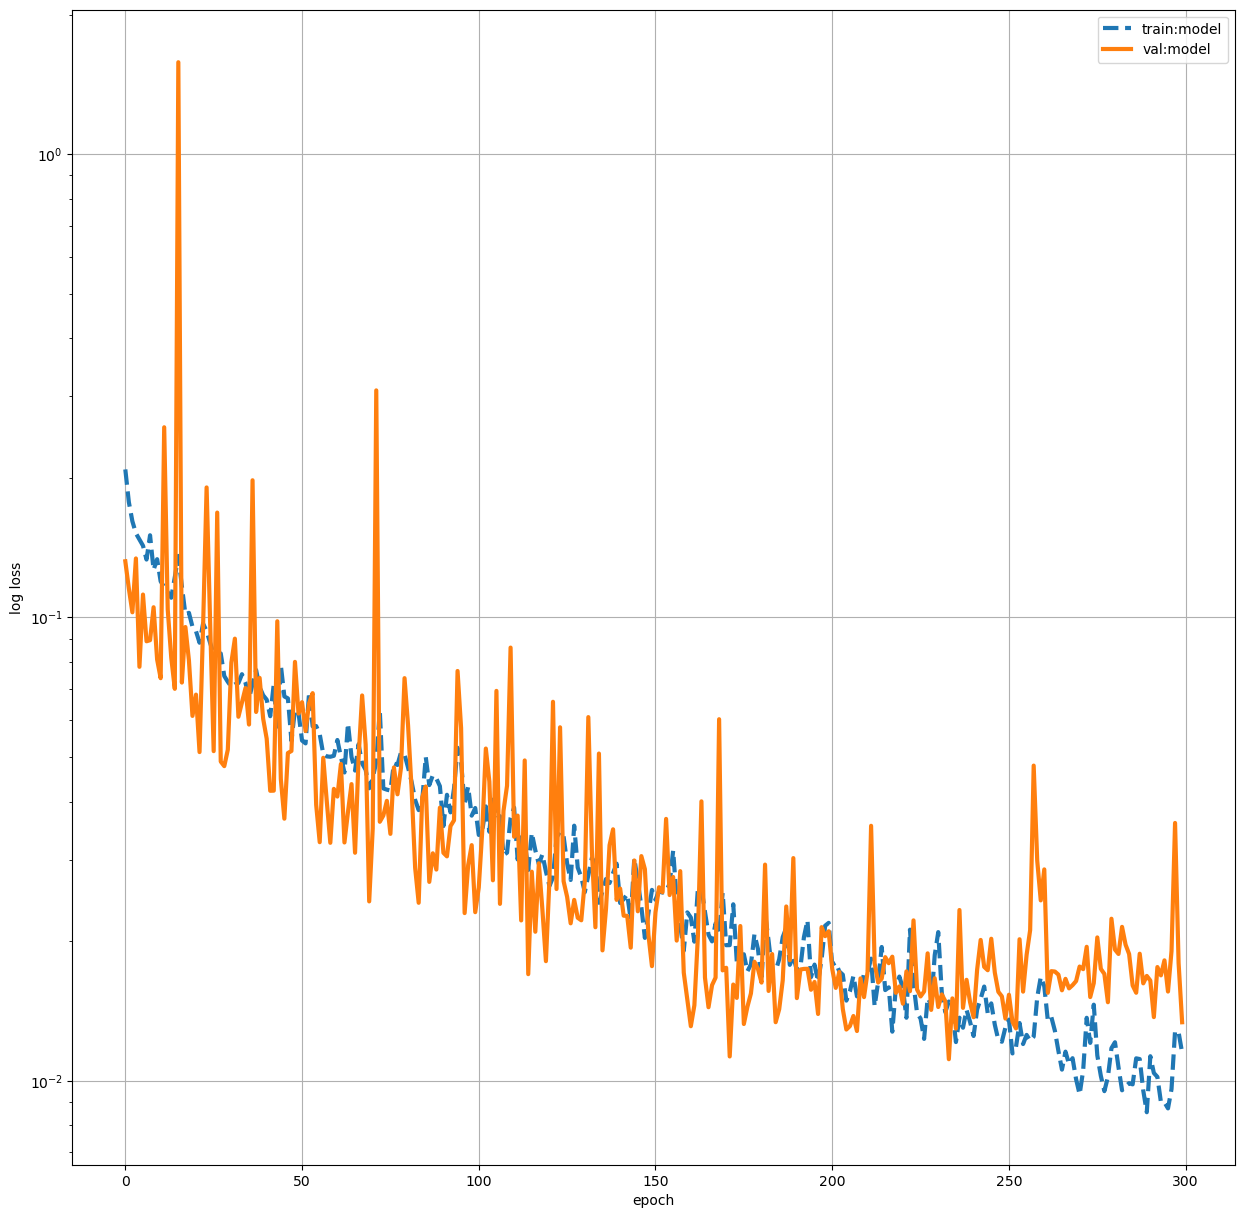

In [35]:
plt.figure(figsize=(15,15))
plot_loss(history.history,"model",plt)
plt.legend()
plt.grid()
plt.yscale("log")
plt.xlabel("epoch")
plt.ylabel("log loss")
plt.show()

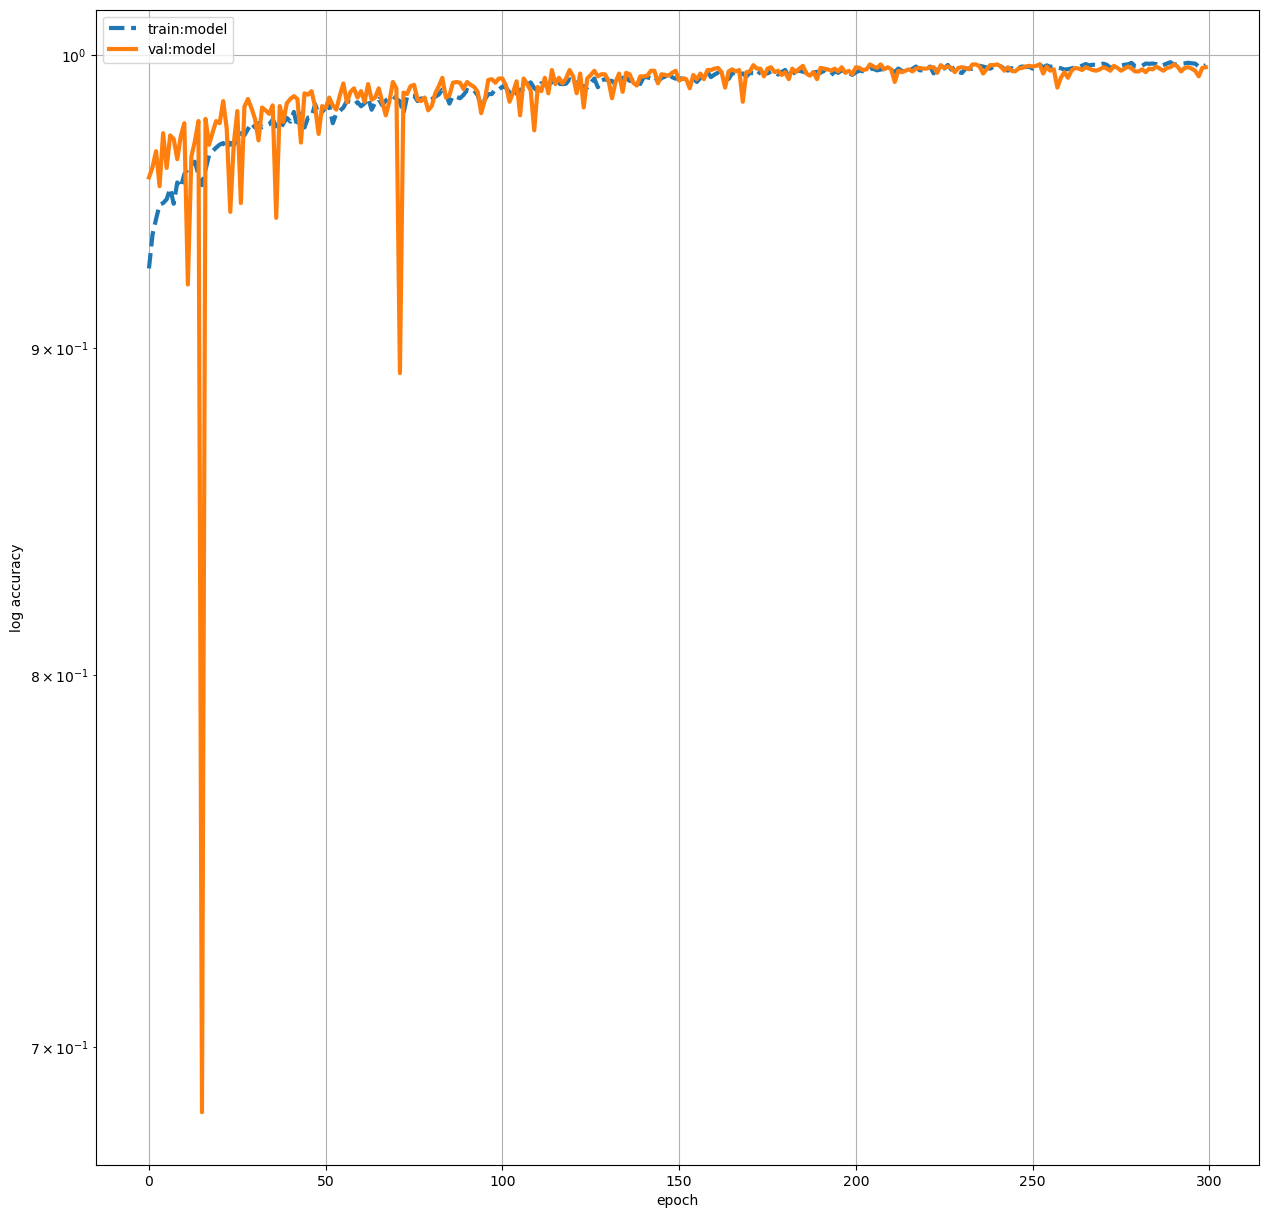

In [36]:
plt.figure(figsize=(15,15))
plot_accuracy(history.history,"model",plt)
plt.legend()
plt.grid()
plt.yscale("log")
plt.xlabel("epoch")
plt.ylabel("log accuracy")
plt.show()

## Delete the existing model + Load the best one

In [37]:
# Delete the existing model
del model

# Load last saved model
model = load_model(model_name + ".h5")

# Look at confusion matrix

 25/125 [=====>........................] - ETA: 0s

2022-10-01 14:32:55.121596: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


125/125 [==============================] - 1s 6ms/step


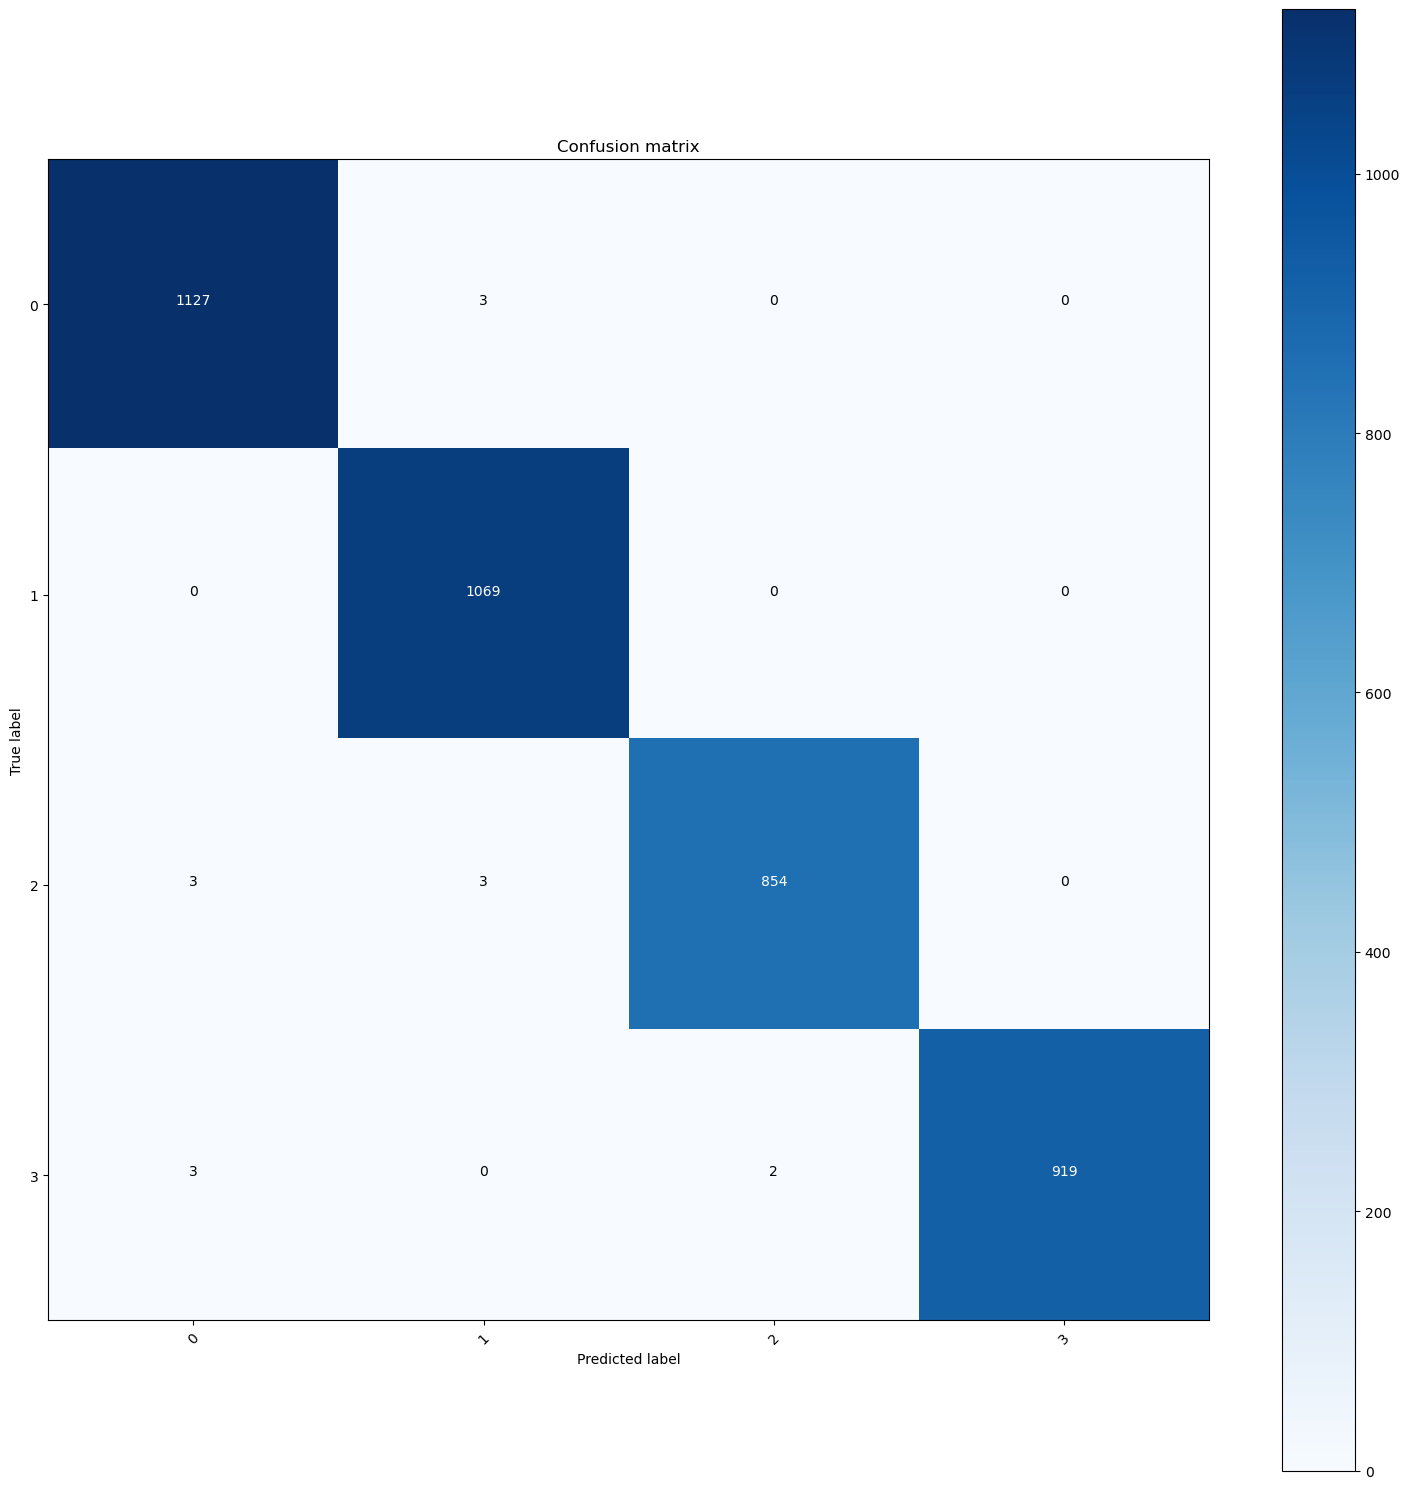

In [38]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    plt.figure(figsize=(15, 15))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred,axis = 1)
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1)
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(num_classes))

In [39]:
# Verify the shapes
print("Y_pred shape: ", Y_pred.shape)                 # Prediction for each image in the validaset set
print("Y_pred_classes shape: ", Y_pred_classes.shape) # Index of the font prediction for each image in the val. set
print("Y_true shape: ", Y_true.shape)                 # Index of the actual font for each image in the val. set
print("confusion_mtx shape: ", confusion_mtx.shape)   # Values in the confusion matrix shown above

Y_pred shape:  (3983, 4)
Y_pred_classes shape:  (3983,)
Y_true shape:  (3983,)
confusion_mtx shape:  (4, 4)


In [40]:
X_val.shape

(3983, 70, 70, 1)

## Analyze the errors

In [41]:
# Errors are difference between predicted labels and true labels. Error[i] is True if this is an error
errors = (Y_pred_classes - Y_true != 0)

# Y_pred_errors: List of Images in the validation set where prediction was bad
X_val_errors = X_val[errors]

# Y_true_errors: Index of the actual font in the validation set where prediction was bad
Y_true_errors = Y_true[errors]

# Y_pred_classes_errors: The list of indexes for font predictions that were bad
Y_pred_classes_errors = Y_pred_classes[errors]

# Y_pred_errors: Prediction for each font in the validation set where prediction was bad
Y_pred_errors = Y_pred[errors]

In [42]:
def display_errors(errors_index, img_errors, pred_errors, obs_errors):
    """ This function shows images with their predicted and real labels"""

    fig = plt.figure(figsize=(13, 15))
    fig.subplots_adjust(hspace=0.13, wspace=0.2, left=0, right=1, bottom=0, top=1.1)
    nb_pictures = len(errors_index)
    
    for i in range(nb_pictures):
        ax = fig.add_subplot(nb_pictures//3 , 5, i+1, xticks=[], yticks=[]) 
        error = errors_index[i]
        plot_sample((img_errors[error]).reshape((image_size,image_size)), ax)
        ax.set_title("Pred: {}\nTrue : {}".format(output_labels[pred_errors[error]], output_labels[obs_errors[error]]))
    plt.show() 

## Show the biggest errors

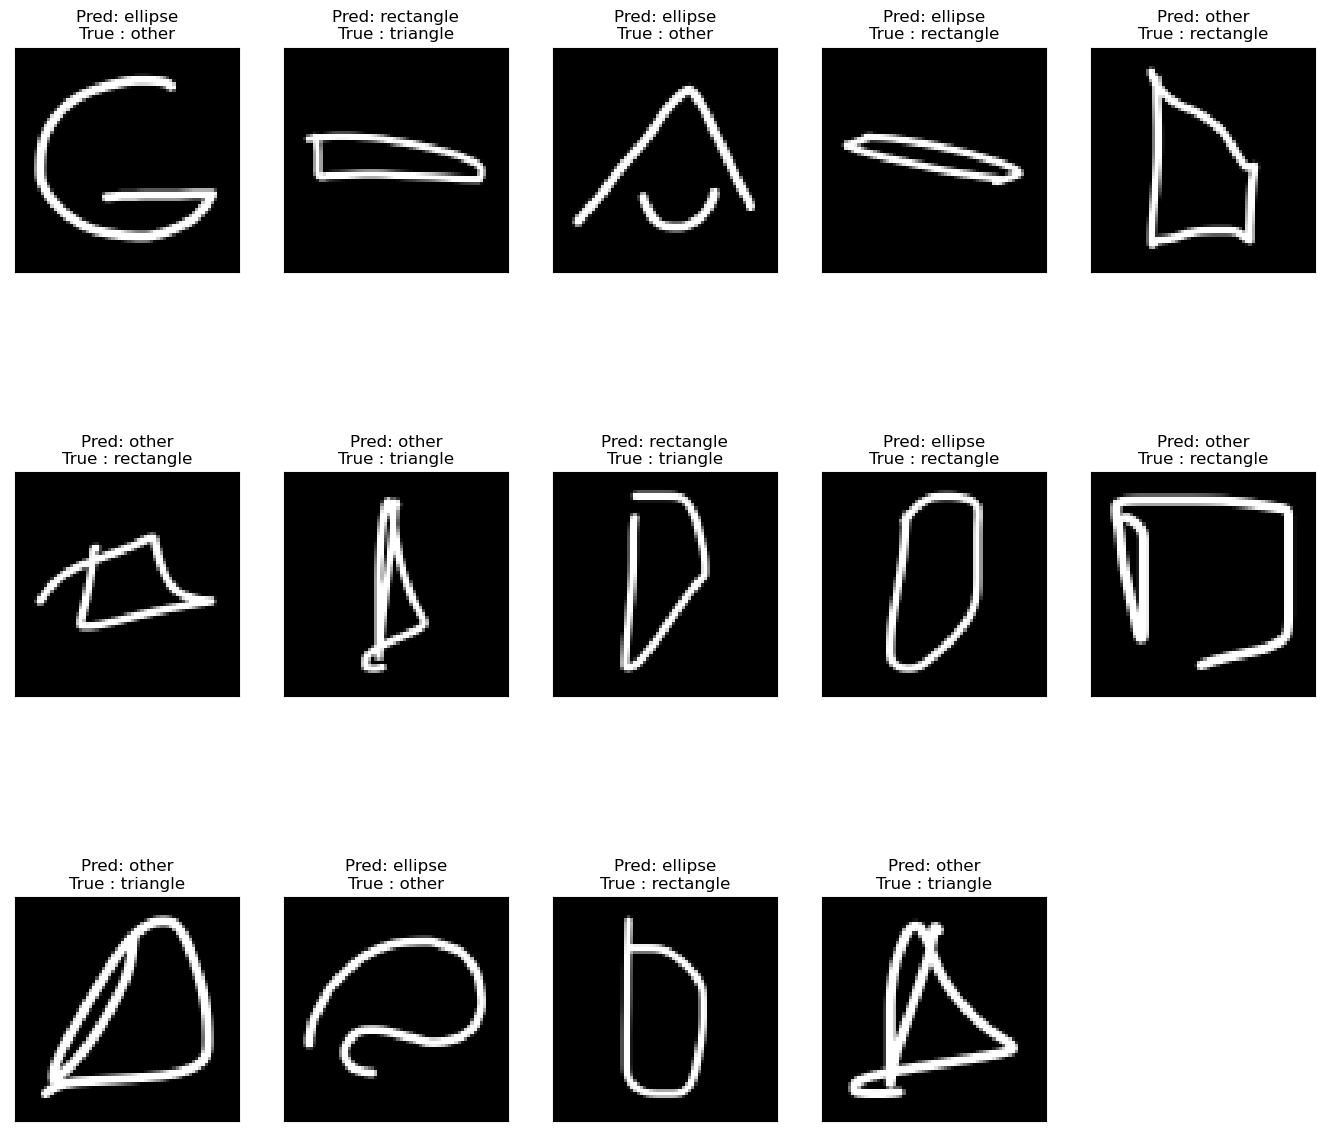

In [43]:
# Probabilities of the wrong predicted numbers. Prob for the bad choice
Y_pred_errors_prob = np.max(Y_pred_errors, axis = 1)

# Predicted probabilities of the true values in the error set. Prob for the good choice
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_delta_errors = np.argsort(delta_pred_true_errors)

# Top errors 
most_important_errors = sorted_delta_errors[-15:]

# Show the top errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

### Conclusion from Confusion matrix and Biggest errors
We see that most errors relate to the differentiation between **Other** and actual shape. 
This is specially true since we allow some incomplete shapes (like some **3 sides rectangles**) to be valid shapes.   
This makes the problem **more difficult**, but also **more interesting**.  
This is useful when the goal is to determine what is the intent of the user drawing shapes. 

## Show Saliency maps - Which pixels were used for predictions

In [44]:
def saliency_map(input_image, model, label, image_size, num_classes):
    '''
    Generates the saliency map of a given gray scale image.

    Args:
        image -- picture that the model will classify
        model (keras Model) -- classifier
        label (int) -- ground truth label of the image
        image_size (int)  -- Image size in pixels
        num_classes (int) -- number of classes for label
    '''

    input_image = input_image.reshape(image_size, image_size)
    
    # Add an additional dimension (for the batch)
    image = np.expand_dims(input_image, axis=0)

    # Define the expected output array by one-hot encoding the label
    # The length of the array is equal to the number of classes
    expected_output = tf.one_hot([label] * image.shape[0], num_classes)
   
    with tf.GradientTape() as tape:
        # cast image to float
        inputs = tf.cast(image, tf.float32)

        # watch the input pixels
        tape.watch(inputs)

        # generate the predictions
        predictions = model(inputs)

        # Calculate the loss
        loss = tf.keras.losses.categorical_crossentropy(expected_output, predictions)

    # get the gradients of the loss with respect to the model's input image
    gradients = tape.gradient(loss, inputs)
    
    # generate the grayscale tensor
    grayscale_tensor = tf.abs(gradients[0])

    # The max value in the grayscale tensor will be pushed to 1.0
    # The min value will be pushed to 0.
    normalized_tensor = (grayscale_tensor - tf.reduce_min(grayscale_tensor)) / \
         (tf.reduce_max(grayscale_tensor) - tf.reduce_min(grayscale_tensor))
    
    # Mix the saliency map with the original image
    mixed_image = input_image * 0.5 + normalized_tensor * 0.5

    return mixed_image.numpy(), normalized_tensor.numpy()

In [45]:
def display_images_with_saliency_map(X, Y):
    """ This function shows Saliency maps for images with their real labels"""
    
    fig = plt.figure(figsize=(7, 26))
    fig.subplots_adjust(hspace=0.05, wspace=0.5, left=0, right=1, bottom=0, top=1.2)
    nb_pictures = 15
    m = 0
    
    for i in range(nb_pictures):
        image_with_saliency, normalized_tensor = saliency_map(X[i], model, Y[i], image_size, num_classes)
        
        if np.isnan(image_with_saliency[0,0]):
            # TODO Investigate when this condition occurs exactly
            continue

        ax = fig.add_subplot(nb_pictures, 3, (m*3)+1, xticks=[], yticks=[]) 
        plot_sample(X[i].reshape((image_size, image_size)), ax)
        ax.set_title("{}".format(output_labels[Y[i]]))
        
        ax = fig.add_subplot(nb_pictures, 3, (m*3)+2, xticks=[], yticks=[]) 
        plot_sample(normalized_tensor.reshape((image_size, image_size)), ax)
        ax.set_title("Saliency")


        ax = fig.add_subplot(nb_pictures, 3, (m*3)+3, xticks=[], yticks=[]) 
        plot_sample(image_with_saliency.reshape((image_size, image_size)), ax)
        ax.set_title("Combined")
        
        m += 1

    plt.show()

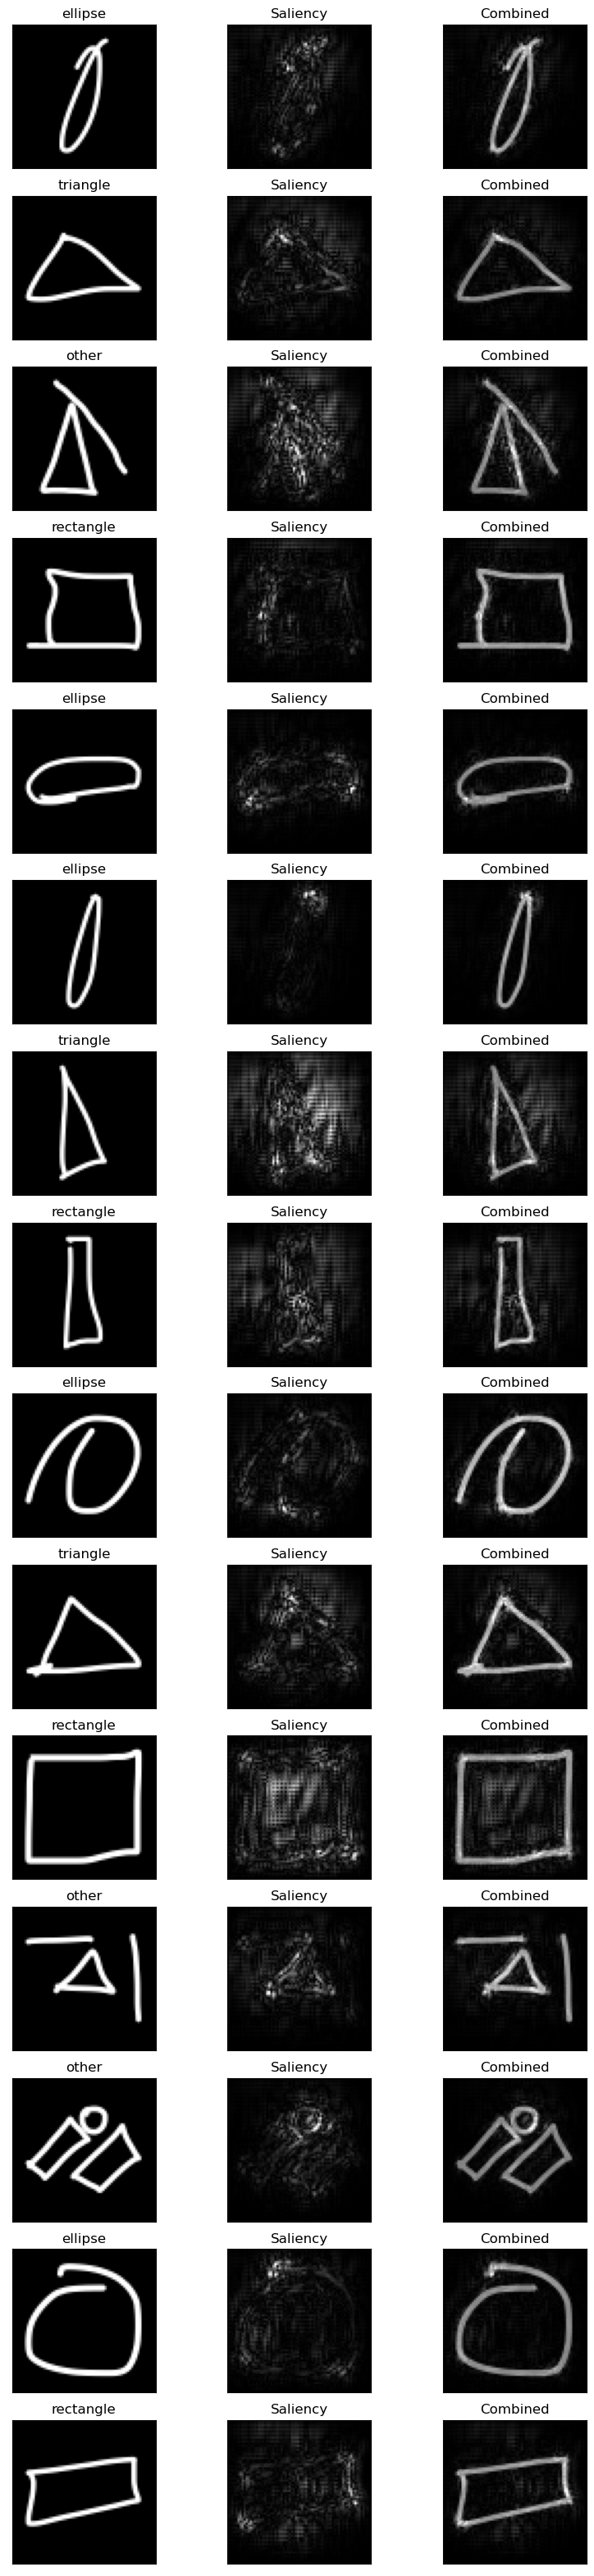

In [46]:
# Do a visualization of which pixels the model is focusing on when making its predictions
display_images_with_saliency_map(X_val[first_random_indexes_va], val_y[first_random_indexes_va])

### Conclusion from Saliency 
In most cases, Saliency maps seem to give a good intuition of what was considered special in a specific image (like the vertices of a rectangle).

## Predict for the test set

In [47]:
## Prepare test set
test_X = test_dict['test_data']
test_y = test_dict['test_labels']
print("test_X shape: ", test_X.shape)
print("test_y shape: ", test_y.shape)

X_test    = test_X.reshape(-1,image_size,image_size,1)
Y_test    = to_categorical(test_y, num_classes = num_classes)
print("X_test shape: ", X_test.shape)
print("Y_test shape: ", Y_test.shape)

test_X shape:  (1923, 70, 70)
test_y shape:  (1923,)
X_test shape:  (1923, 70, 70, 1)
Y_test shape:  (1923, 4)


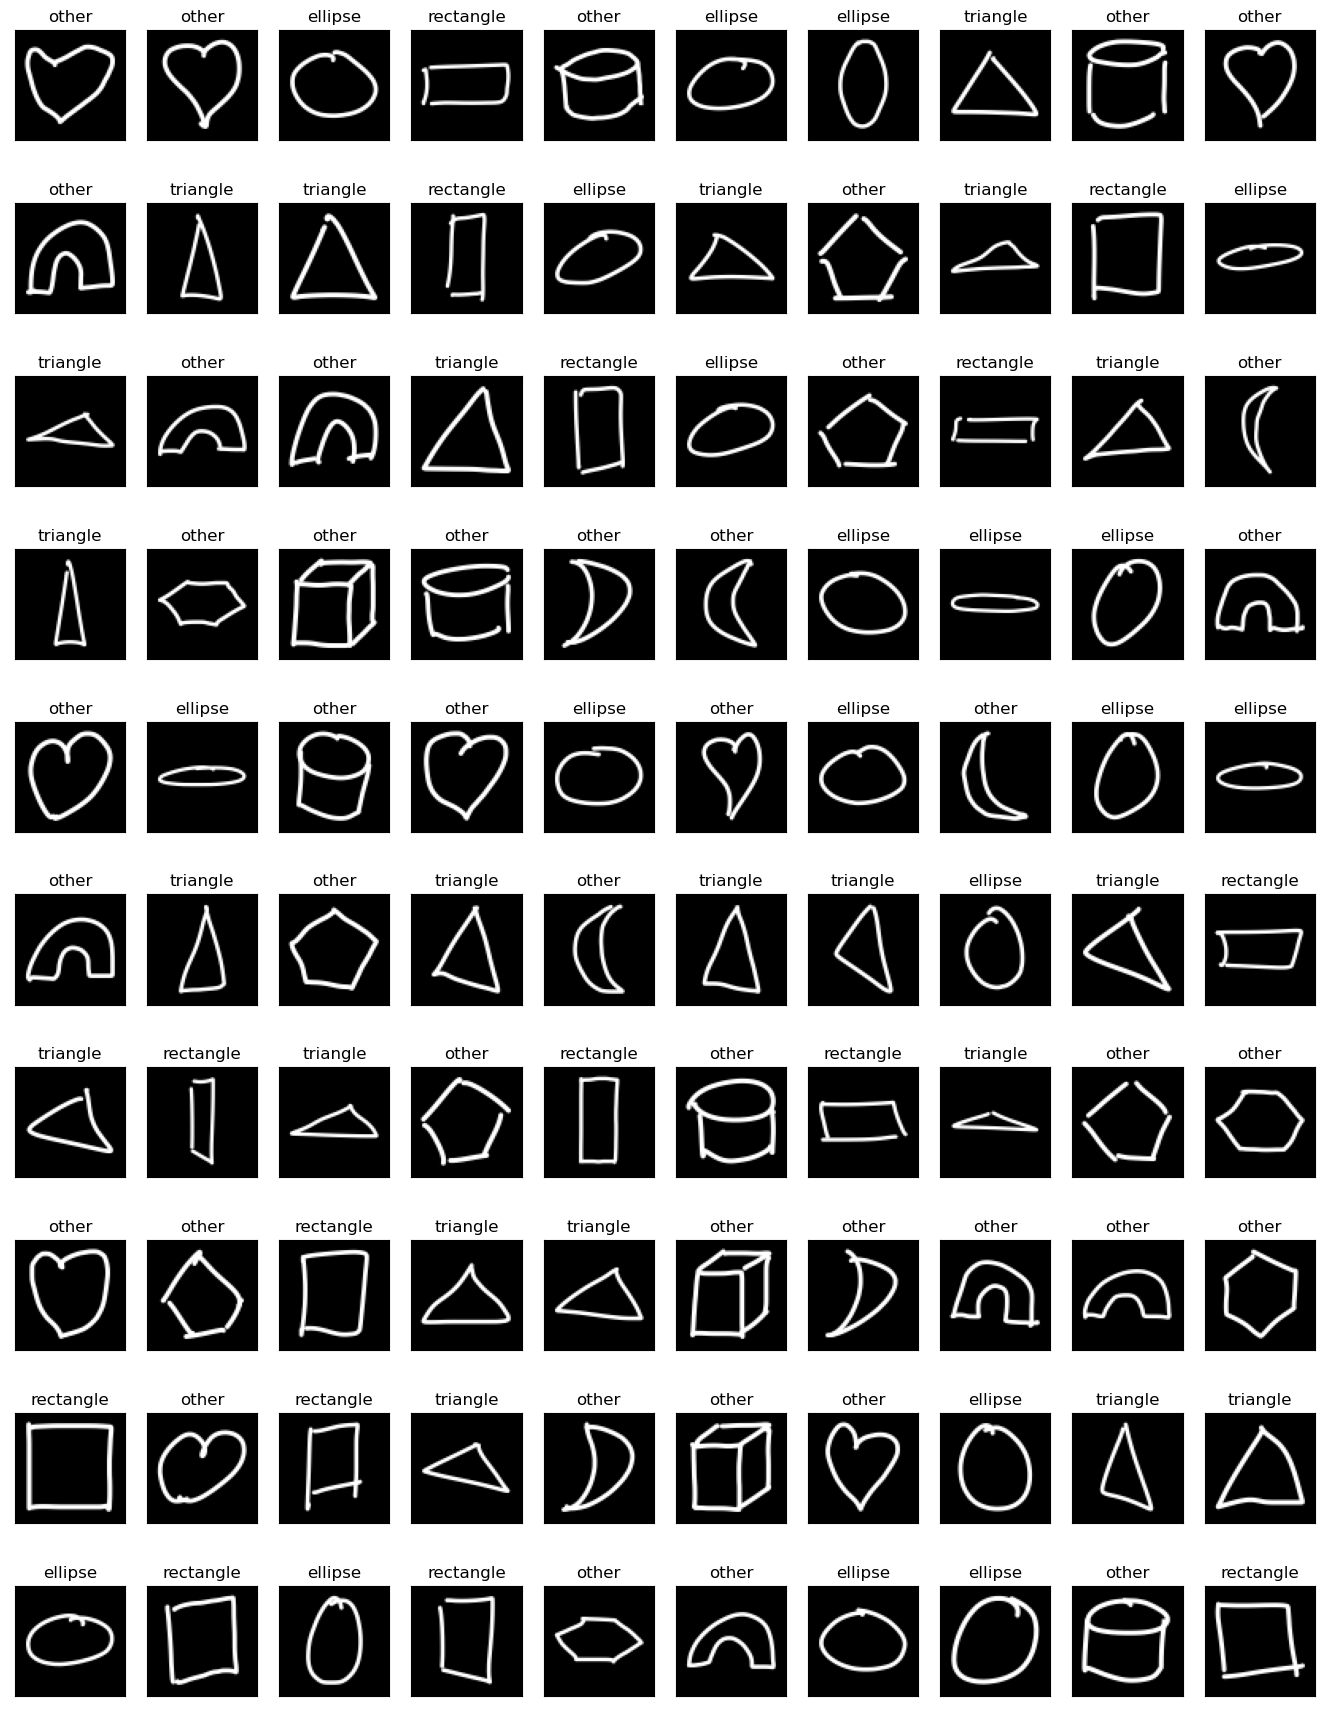

In [48]:
# Show random images from the test Set
indexes = np.arange(len(test_y))
np.random.shuffle(indexes)
first_random_indexes_te = indexes[:100]

display_images(X_test[first_random_indexes_te], test_y[first_random_indexes_te])

## Show accuracy for the test set

In [49]:
test_loss, test_acc = model.evaluate(X_test, Y_test)
print("test_acc: ", test_acc)

 7/61 [==>...........................] - ETA: 0s - loss: 0.0032 - accuracy: 1.0000     

2022-10-01 14:33:00.339276: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


61/61 [==============================] - 1s 11ms/step - loss: 0.0014 - accuracy: 0.9995
test_acc:  0.9994800686836243


In [50]:
# All done
datetime.datetime.now()

datetime.datetime(2022, 10, 1, 14, 33, 1, 116484)

# Conclusions
Accuracy is pretty good and was definitively useful in [Mix on Pix](https://apps.apple.com/us/app/mix-on-pix-text-on-photos/id633281586).

## TensorFlow Lite Notes
When creating a TensorFlow Lite model with quantization, accuracy can be a tiny bit lower, but the model size is 25% of the original.